In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
from tools import *

# Partie 1 : SIFT

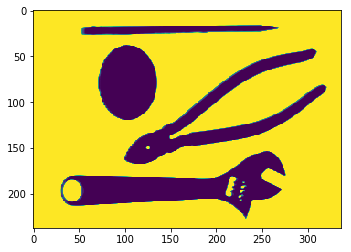

In [2]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I)

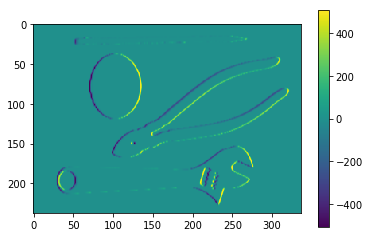

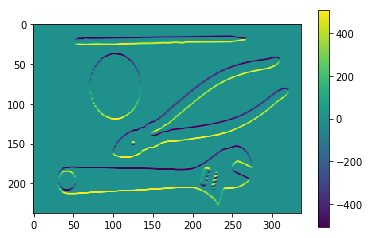

In [3]:
def compute_grad(I):
    """
    """
    ha = np.array([1/2, 1, 1/2])
    hb = np.array([-1, 0, 1])
    Ix = conv_separable(I, hb, ha)
    Iy = conv_separable(I, ha, hb)
    
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [4]:
def compute_grad_mod_ori(I):
    """
    """
    Ix, Iy = compute_grad(I)
    Gm = np.sqrt((Ix**2 + Iy**2))
    Go = compute_grad_ori(Ix, Iy, Gm)
    return Gm, Go

In [18]:
def compute_sift_region(Gm, Go, mask=None):
    """ Return an array of 128 values 
    """
    # TODO
    # Note: to apply the mask only when given, do:
    sift_size = 128
    patch_size = 16
    sr_size = 4
    Gm_pond = Gm
    if mask is not None:
        Gm_pond = Gm * mask
   
    P_enc  = []    
    for i in range(0, patch_size, sr_size):
        for j in range(0, patch_size, sr_size):
            for k in range(8):
                srm = Gm[i:i+sr_size, j:j+sr_size]
                sro = Go[i:i+sr_size, j:j+sr_size]
                ind_k = np.where(sro == k)
                P_enc.append(srm[ind_k].sum())
 
    # Post processing
    if np.linalg.norm(P_enc) < 0.5:
        return np.zeros(sift_size)
    else:
        norm = np.linalg.norm(P_enc, ord=2)
        P_enc /= norm
        # Indices where value is superior to zeros.deux
        ind_szd = np.where(P_enc > 0.2)[0]
        if len(ind_szd) > 0:
            P_enc[ind_szd] = 0.2
            P_enc /= norm
                             
    return P_enc


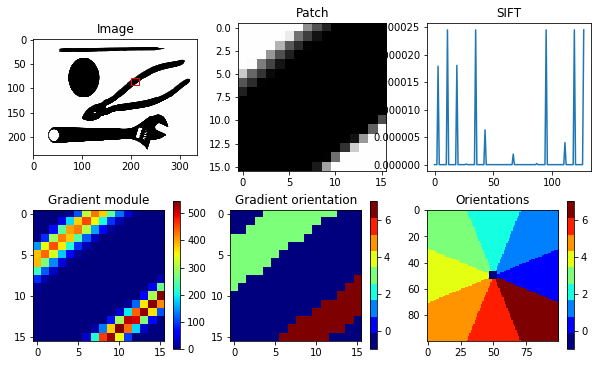

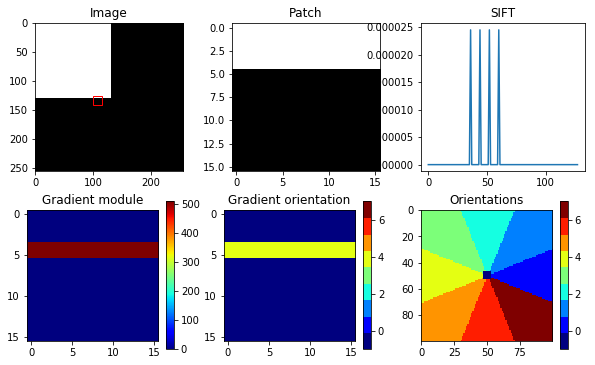

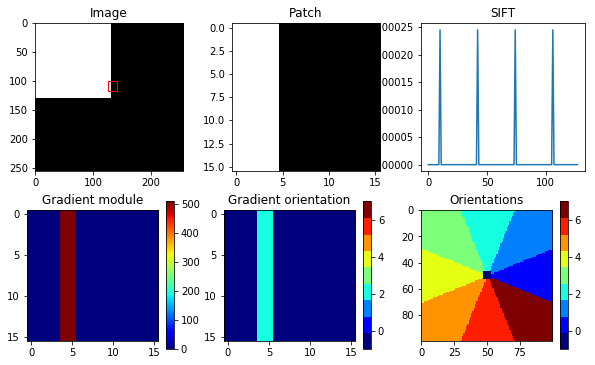

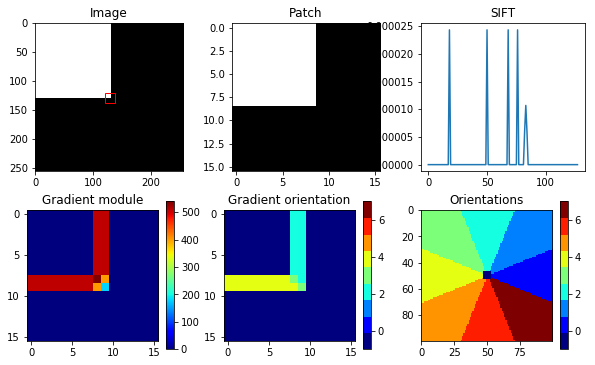

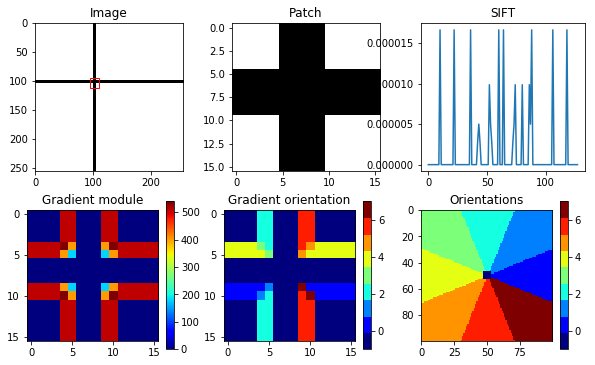

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.66664275e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.66664275e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.66664275e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.79985297e-06, 5.00852926e-06,
       2.79985297e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.88298298e-06, 5.00852926e-06, 2.79985297e-06, 0.00000000e+00,
      

In [19]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I, compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [7]:
def compute_sift_image(I):
    """
    """
    x, y = dense_sampling(I)
    im = auto_padding(I)
    k, sift_size = 16, 128
    g_m, g_o = compute_grad_mod_ori(im)
    
    # calculs communs aux patchs
    sifts = np.zeros((len(x), len(y), sift_size))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            g_m_r = g_m[xi:xi+k, yj:yj+k]
            g_o_r = g_o[xi:xi+k, yj:yj+k]
            sift = compute_sift_region(g_m_r, g_o_r)
            # SIFT du patch de coordonnee (xi, yj)
            sifts[i, j, :] = sift
            print(sifts[i, j, :])
            
    return sifts

# Partie 2 : Dictionnaire visuel

In [14]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
from tools import *
from sift import *

from sklearn.cluster import KMeans

In [15]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift')
path_vdict = os.path.join('data', 'kmeans', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')

inames, ilabls, cnames = load_dataset(dir_sc)

In [10]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


In [11]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    sift_size = 128
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    
    # compute kmeans on `sift`, get cluster centers, add zeros vector
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, verbose=verbose)
    kmeans.fit(sift)
    clusters = kmeans.cluster_centers_
    
    return np.vstack((clusters, np.zeros(sift_size).reshape(1, -1)))

In [12]:
# Run the visual dict computation (saved the first time)
vidct = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict


(232, 344)
(232, 304)
(232, 304)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(264, 264)
(232, 304)
(264, 264)
(264, 264)
(232, 344)
(264, 264)
(264, 264)
(232, 344)
(264, 264)
(264, 264)
(264, 264)
(296, 232)
(232, 304)
(232, 304)
(256, 232)
(264, 264)
(232, 304)
(264, 264)
(232, 352)
(264, 264)
(232, 304)
(264, 264)


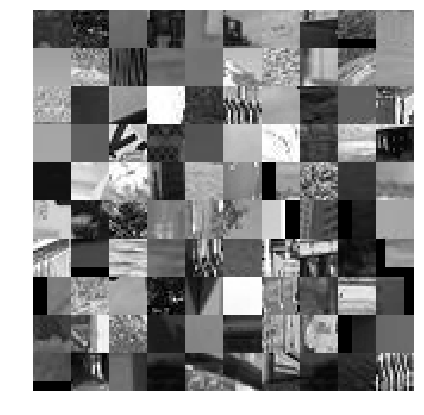

In [13]:
# Study of the dict
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 30)) # Compute SIFT and regions from 30 random images
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

# TODO visually analyze the dict through similar example regions
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

# Partie 3 : BoW

In [ ]:
# Compute BoW for an image

def compute_feats(vdict, image_sifts):
    # TODO compute BoW from `image_sifts`
    return

In [ ]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here